In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

# Dataset Exploration

# Handling Missing Data, Categorical Variables

In [3]:
path = '/content/drive/MyDrive/BCN-Apartments/'
#path = '/Users/maelys/Desktop/BSE/BSE - Courses/DM012 Machine Learning/Project/'
# Load the Training dataset
df_bcn = pd.read_csv(path + 'train.csv')

# Display the first few rows of the DataFrame
display(df_bcn.head())

df = df_bcn

,id,num_rooms,num_baths,square_meters,orientation,year_built,door,is_furnished,has_pool,neighborhood,num_crimes,has_ac,accepts_pets,num_supermarkets,price
0,9255,1.0,1.0,NaN,NaN,1956.0,3º - 1a,False,False,Sant Martí,2.0,True,True,NaN,1096
1,1562,4.0,1.0,133.0,west,1960.0,7º - 2a,False,False,Sants,4.0,False,False,2.0,1396
2,1671,2.0,3.0,137.0,NaN,2000.0,1º - 1a,False,True,Eixample,0.0,False,False,NaN,1263
3,6088,1.0,2.0,-41.0,NaN,2002.0,6º - 1a,False,True,Sants,5.0,False,False,NaN,1290
4,6670,2.0,1.0,70.0,NaN,1979.0,5º - 1a,True,False,Gràcia,0.0,False,True,3.0,962


### Deleting Columns with 80% or more missing values

In [4]:
# Calculate the percentage of missing values in each column
missing_percentages = df.isnull().sum() / len(df) * 100
print(missing_percentages)

# Define the threshold for dropping columns (80% or more missing values)
threshold = 85

# Get the column names that exceed the threshold
columns_to_drop = missing_percentages[missing_percentages >= threshold].index

# Drop the columns from the DataFrame
df = df.drop(columns_to_drop, axis=1)

id                   0.0000
num_rooms            0.0000
num_baths            2.0000
square_meters        1.9375
orientation         29.2625
year_built           2.1250
door                 1.8625
is_furnished         2.0625
has_pool             1.9500
neighborhood         2.0625
num_crimes           2.0000
has_ac               2.1125
accepts_pets         1.9375
num_supermarkets    82.3625
price                0.0000
dtype: float64


### Figure out what to do with door (maybe floor?) and id?

In [5]:
df['floor'] = df['door'].str.split('º').str[0].astype(float)
df = df.drop(columns = ['door', 'id'])

### True/False: is_furnished, has_pool, has_ac, accepts_pets,

Categorical: neighborhood, orientation

In [6]:
# Define the mapping for ordinal encoding
mapping = {True: 1, False: 0}

# Apply ordinal encoding to the 'color' column using the mapping
df['is_furnished'] = df['is_furnished'].map(mapping)
df['has_pool'] = df['has_pool'].map(mapping)
df['has_ac'] = df['has_ac'].map(mapping)
df['accepts_pets'] = df['accepts_pets'].map(mapping)

### Orientation

In [7]:
# orientation column had a typo: 'soxth' (same encoding as south)
map_orientation = {'north':1,'east':2, 'south':3, 'west':4, 'soxth':3}

df['orientation'] = df['orientation'].map(map_orientation)

### Target Encoding: Neighborhood

In [8]:
# Calculating the mean price for each neighborhood
mean_price_by_neighborhood = df.groupby('neighborhood')['price'].mean()
df['neighborhood'] = df['neighborhood'].map(mean_price_by_neighborhood)

### KNN

In [9]:
from sklearn.impute import KNNImputer

# Create KNNImputer object with k=2
imputer = KNNImputer(n_neighbors=2)

# Perform KNN imputation
imputed_data = imputer.fit_transform(df)

# Convert the imputed data back to DataFrame
df = pd.DataFrame(imputed_data, columns=df.columns)

# Addressing Categorical Features and Outliers

### Square Meters has negative values (they should all be switched to positive values)

In [10]:
df['square_meters'] = df['square_meters'].abs()

### number of rooms is huge:

The list of outliers are [93.0, 47.0, 87.0, 79.0, 82.0, 70.0, 75.0, 73.0, 43.0, 57.0, 48.0, 92.0, 46.0, 42.0, 78.0, 81.0, 83.0, 91.0, 41.0, 90.0, 83.0, 56.0, 60.0, 53.0, 41.0, 94.0, 62.0, 86.0, 50.0, 97.0, 83.0, 41.0, 75.0, 76.0, 49.0, 63.0, 97.0, 68.0, 78.0, 96.0, 47.0, 53.0, 61.0, 43.0, 91.0, 45.0]


In [11]:
import numpy as np
from scipy.stats import zscore

### CHANGE CODE: MEDIAN

def impute_outliers_mean(data, threshold=3):
    """
    Impute outliers in a dataset by replacing them with the mean of the non-outlying values.

    Arguments:
    - data: 1-D array or list, the dataset containing outliers.
    - threshold: Float, the threshold value in terms of standard deviations.

    Returns:
    - imputed_data: 1-D array, the dataset with outliers imputed using mean imputation.
    """
    # Compute the z-scores for each data point
    z_scores = np.abs(zscore(data))

    # Find the indices of outliers based on the threshold
    outlier_indices = np.where(z_scores > threshold)[0]

    # Make a copy of the data for imputation
    imputed_data = np.copy(data)

    # Calculate the mean of non-outlying values
    non_outliers_mean = np.median(imputed_data[np.where(z_scores <= threshold)])

    # Replace outliers with the mean of non-outlying values
    imputed_data[outlier_indices] = non_outliers_mean

    return imputed_data


imputed_data = impute_outliers_mean(df['num_rooms'], threshold=3)

df['num_rooms'] = imputed_data

### variables that have no outliers:

*   num_baths
*   is_furnished
*   orientation
*   year_built
*   has_pool
*   neighborhood
*   num_crimes

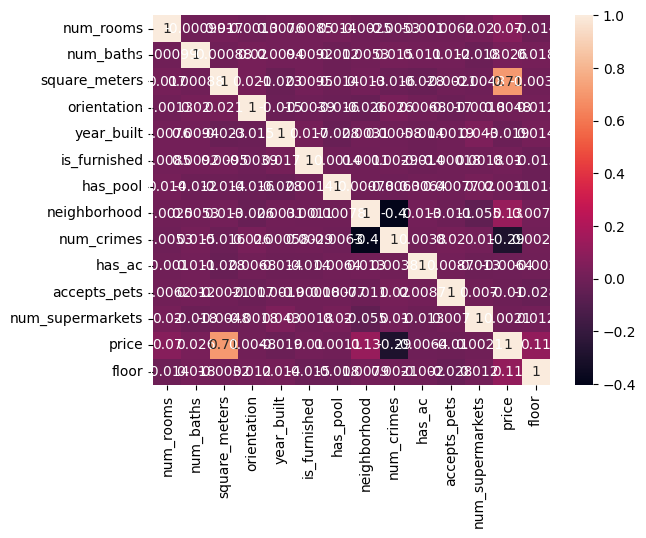

In [12]:
corr_matrix = df.corr()
#print(corr_matrix)

import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(corr_matrix, annot=True)
sns.set(rc={'figure.figsize':(10,10)})

plt.show()

# Model Building

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = df.drop(columns = ['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Gradient Boosting Regressor
* Lasso:
  * 0.6188485120004438
  * 28423.6009342807
* Gradient Boosting:
  * 0.6263837857044354
  * 27861.67314589151


In [15]:
from sklearn.linear_model import Lasso

reg = Lasso(random_state=0)
reg.fit(X_train, y_train)
print(reg.score(X_test, y_test))

y_pred = reg.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.6263837857044354
27861.67314589151


In [16]:
reg = Lasso(random_state=0)
reg.fit(X, y)

GradientBoostingRegressor(random_state=0)

# Assessing Accuracy with Cross-Validation

### MSE

submission file: example \\
id,price \\
2,0


In [17]:
stop

NameError: ignored

In [ ]:
# Load the Testing dataset
df = pd.read_csv(path + 'test.csv')

In [ ]:
#df['door'].unique()
#df = df.drop(columns = ['num_supermarkets'])

df['floor'] = df['door'].str.split('º').str[0].astype(float)
df = df.drop(columns = ['door'])

# Apply ordinal encoding to the 'color' column using the mapping
df['is_furnished'] = df['is_furnished'].map(mapping)
df['has_pool'] = df['has_pool'].map(mapping)
df['has_ac'] = df['has_ac'].map(mapping)
df['accepts_pets'] = df['accepts_pets'].map(mapping)
df['orientation'] = df['orientation'].map(map_orientation)
df['neighborhood'] = df['neighborhood'].map(mean_price_by_neighborhood)

# Perform KNN imputation
imputed_data = imputer.fit_transform(df)
# Convert the imputed data back to DataFrame
df = pd.DataFrame(imputed_data, columns=df.columns)

df['square_meters'] = df['square_meters'].abs()

imputed_data = impute_outliers_mean(df['num_rooms'], threshold=3)
df['num_rooms'] = imputed_data

In [ ]:
X_test = df.drop(columns = ['id'])
y_pred_test = reg.predict(X_test)

In [ ]:
frame = {'id': df['id'],
         'price': pd.DataFrame(y_pred_test)[0]}

# Creating DataFrame by passing Dictionary
result = pd.DataFrame(frame)
result.to_csv(path + 'results_sklearn_04-v2lasso.csv', index=False)

# Identifying Impactful Variables

In [ ]:
# square meters is most impactful variables